<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/optimization/admm_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install qiskit-aer
!pip install qiskit-machine-learning
!pip install qiskit-optimization

In [3]:
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.translators import from_docplex_mp

<ipython-input-3-d2466b5b0c9e>:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver


In [4]:
# define COBYLA optimizer to handle convex continuous problems.
cobyla = CobylaOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(sampler=Sampler(), optimizer=COBYLA()))

# exact QUBO solver as classical benchmark
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

In [5]:
# construct model using docplex
mdl = Model("ex6")

v = mdl.binary_var(name="v")
w = mdl.binary_var(name="w")
t = mdl.binary_var(name="t")
u = mdl.continuous_var(name="u")

mdl.minimize(v + w + t + 5 * (u - 2) ** 2)
mdl.add_constraint(v + 2 * w + t + u <= 3, "cons1")
mdl.add_constraint(v + w + t >= 1, "cons2")
mdl.add_constraint(v + w == 1, "cons3")

# load quadratic program from docplex model
qp = from_docplex_mp(mdl)
print(qp.prettyprint())

Problem name: ex6

Minimize
  5*u^2 + t - 20*u + v + w + 20

Subject to
  Linear constraints (3)
    t + u + v + 2*w <= 3  'cons1'
    t + v + w >= 1  'cons2'
    v + w == 1  'cons3'

  Continuous variables (1)
    0 <= u

  Binary variables (3)
    v w t



### Classical Solution

In [6]:
admm_params = ADMMParameters(
    rho_initial=1001, beta=1000, factor_c=900, maxiter=100, three_block=True, tol=1.0e-6
)

In [7]:
# define QUBO optimizer
qubo_optimizer = exact
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(
    params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer
)

In [8]:
result = admm.solve(qp)

In [9]:
print(result.prettyprint())

objective function value: 1.0
variable values: v=1.0, w=0.0, t=0.0, u=2.0
status: SUCCESS


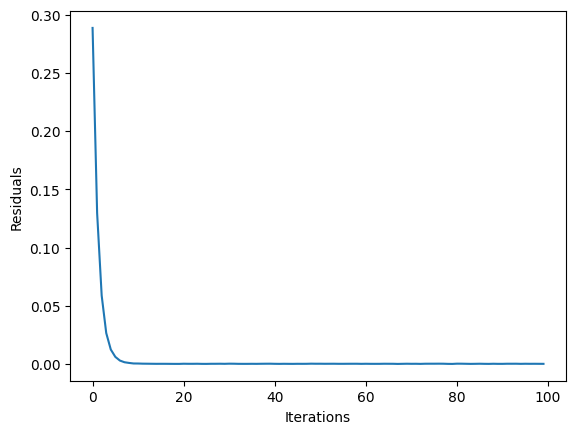

In [10]:
plt.plot(result.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

### Quantum Solution

In [11]:
# define QUBO optimizer
qubo_optimizer = qaoa

# define classical optimizer
convex_optimizer = cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with quantum QUBO optimizer and classical convex optimizer
admm_q = ADMMOptimizer(
    params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer
)

In [12]:
# run ADMM to solve problem
result_q = admm_q.solve(qp)

In [13]:
print(result.prettyprint())

objective function value: 1.0
variable values: v=1.0, w=0.0, t=0.0, u=2.0
status: SUCCESS


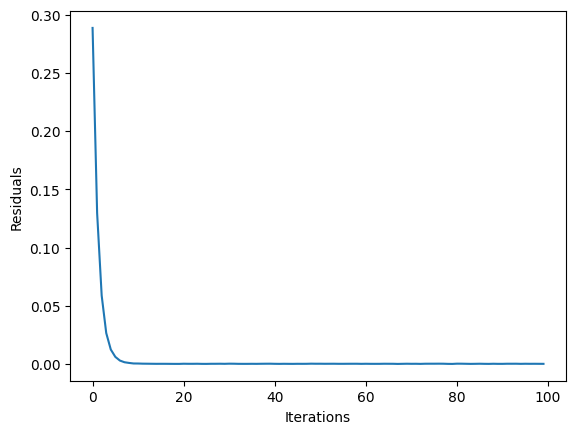

In [14]:
plt.clf()
plt.plot(result_q.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()